In [12]:
import json
import pandas as pd
import geopandas as gpd
from utils import *
from shapely.affinity import scale, translate

In [13]:
# Load data, votes_dataset is the voting data and const_2024 is constituency boundaries
votes_dataset = pd.read_csv('./sim_data/votes_2024.csv')
with open('./sim_data/const_2024.geojson', 'r') as f:
    gj = json.load(f)
const_2024_gdf = gpd.GeoDataFrame.from_features(gj["features"])

# Remove special characters from constituency name fields to properly join the datasets (needed for some welsh names)
const_2024_gdf["PCON24NM"] = const_2024_gdf["PCON24NM"].str.replace(r'[^a-zA-Z]', '', regex=True)
votes_dataset["Constituency name"] = votes_dataset["Constituency name"].str.replace(r'[^a-zA-Z]', '', regex=True)

# Merge datasets on constituency name
merged_data = pd.merge(const_2024_gdf, votes_dataset, left_on="PCON24NM", right_on="Constituency name", how="outer")

In [14]:
# Plot original constituencies
constituencies = []
for i in range(len(merged_data)):
    constituencies.append(merged_data.iloc[i]["geometry"])

In [15]:
# Get NI generated cons
with open('./generated_constituencies/ni_test.geojson', 'r') as f:
    gj = json.load(f)
new_cons_gdf = gpd.GeoDataFrame.from_features(gj["features"])
list_new_cons = []
for i in range(len(new_cons_gdf)):
    list_new_cons.append(new_cons_gdf.iloc[i]["geometry"])

In [16]:
# Get NI original cons
list_country_cons = []
for i in range(len(merged_data)):
    if merged_data.iloc[i]["Country name"] == "Northern Ireland":
        list_country_cons.append(merged_data.iloc[i]["geometry"])
list_country_cons = remove_islands(list_country_cons)

In [17]:
# Convert constituency sets from lists to multipolygons
new_cons = list_to_multipolygon(list_new_cons)
country_cons = list_to_multipolygon(list_country_cons)

In [ ]:
# country_cons = original geometry
# new_cons = generated geometry
# Scale new_cons to match country_cons

def get_extremes(cons):
    
    # Add all coordinates to all_coords
    all_coords = []

    for geom in cons.geoms:
        if geom.geom_type == "Polygon":
            all_coords.extend(geom.exterior.coords)
        elif geom.geom_type == "MultiPolygon":
            for poly in geom.geoms:
                all_coords.extend(poly.exterior.coords)
    
    # Find extreme points
    leftmost = min(all_coords, key=lambda p: p[0])
    rightmost = max(all_coords, key=lambda p: p[0])
    bottommost = min(all_coords, key=lambda p: p[1])
    topmost = max(all_coords, key=lambda p: p[1])

    return leftmost, rightmost, bottommost, topmost


In [19]:
def scale_geom(source_geom, target_geom):

    # Get extremes
    source_extremes = get_extremes(source_geom)
    target_extremes = get_extremes(target_geom)

    # Calculate width and heights
    source_width = source_extremes[1][0]-source_extremes[0][0]
    source_height = source_extremes[3][1]-source_extremes[2][1]
    target_width = target_extremes[1][0]-target_extremes[0][0]
    target_height = target_extremes[3][1]-target_extremes[2][1]

    # Calculate multipliers for each point
    x_mult = target_width/source_width
    y_mult = target_height/source_height

    scaled_geom = scale(source_geom, xfact=x_mult, yfact=y_mult, origin='center')

    return scaled_geom

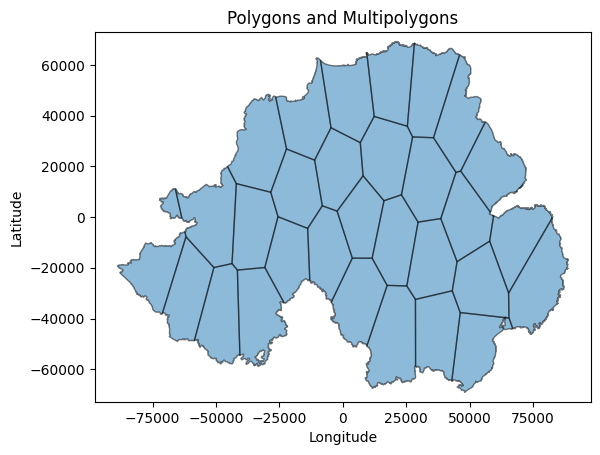

In [20]:
# Scale generated boundaries to the same size as original map
final_new_cons = scale_geom(new_cons, country_cons)
plot_map(final_new_cons)

In [21]:
# Center original map around origin

# Get centroid
country_cons_centroid = country_cons.centroid
dx = -country_cons_centroid.x
dy = -country_cons_centroid.y

# Translate to origin centre
final_country_cons = MultiPolygon([
    translate(polygon, xoff=dx, yoff=dy) for polygon in country_cons.geoms
])

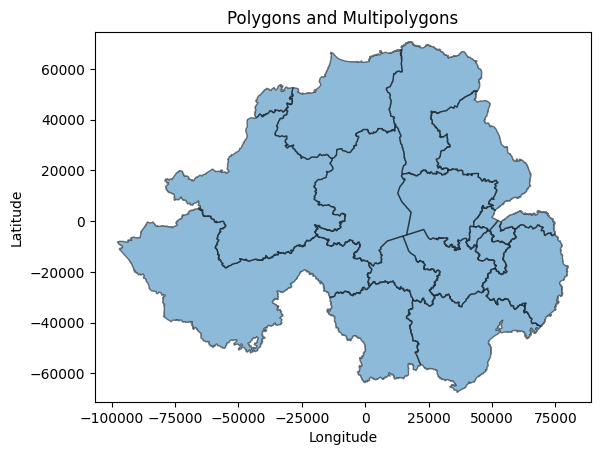

In [22]:
plot_map(final_country_cons)

In [23]:
# For each polygon in new_cons, 